### Fig. 5 | A common risk shared across chronic pain conditions. a ###
Deriving pain-site specific candidate models and comparing them to the risk score.

A. Deriving these alternative models

B. Examining candidat models to predict pain sites they were trained on

1. AUC-ROC Curves of Candidat Models on Test Data (Pain vs Pain-Free)
2. Correlations with Number of Pain Sites of Candidat Models on Test Data

C. Comparing candidat models across predictions

1. Plotting CROSS-SECTIONAL AUC-ROC (One Site vs All-Else)
2. Plotting CROSS-SECTIONAL Bar plots (One Site vs All-Else)

D. Similarity Analysis between Loadings

In [1]:
#### Import Libraries ####
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import linear_model, metrics, cross_decomposition
import matplotlib.pyplot as plt
import matplotlib as mpl
import nltools, math
%matplotlib inline
mpl.rcParams['figure.dpi']= 300
plt.rcParams['font.size'] = 8
sns.set(font="Arial", style = 'white')
fs = 8 #fontsize
Folder = '/Users/Chris/Script_folder/'

In [2]:
# Loading all data
variables, W = pd.read_csv(Folder + '0_Variables_V3.csv'), pd.read_csv(Folder + 'Coefficients_PLSReg_3comp.csv')
variables = variables[variables.coding_finished==1]
variables_T0, variables_T2 = list((variables['Name'] + '_' + variables['T0']).values), list((variables['Name'] + '_' + variables['T2']).values) #List of variables to select
variables['weights'] = W.Coefficients.values

# Computing the risk score
preproc_UKB_Train, preproc_UKB_Test, preproc_UKB_FollowUp = pd.read_csv(Folder + '5_TrainData_PreprocFeatures_Adv.csv'), pd.read_csv(Folder + '5_TestData_PreprocFeatures_Adv.csv'), pd.read_csv(Folder + '6_BrainVisit_PreprocFeatures_Adv.csv')
preproc_UKB_Train['PLS'], preproc_UKB_Test['PLS'], preproc_UKB_FollowUp['PLS'] = np.dot(preproc_UKB_Train[variables_T0], variables['weights']), np.dot(preproc_UKB_Test[variables_T0], variables['weights']), np.dot(preproc_UKB_FollowUp[variables_T2], variables['weights'])

In [3]:
# Matching eid
list_eid = np.intersect1d(preproc_UKB_Test.eid, preproc_UKB_FollowUp.eid)
UKB_T2 = preproc_UKB_Test[preproc_UKB_Test.eid.isin(list_eid)].sort_values(by = 'eid').reset_index(drop=True)
UKB_B = preproc_UKB_FollowUp[preproc_UKB_FollowUp.eid.isin(list_eid)].sort_values(by = 'eid').reset_index(drop=True)

In [4]:
# Pain Sites to examine
Sites1 = ['Pain All Over','Facial','Stomach/Abdo', 'Headaches','Hip','Neck/Shoulder','Back','Knee'] # Long Labels
Sites2 = ['PAO', 'F', 'S/A', 'Ha', 'Hp', 'N/S', 'B', 'K'] #Short labels
P = ['WidespreadPain', 'FacialPain','StomachAbdominalPain','Headaches','HipPain','NeckShoulderPain','BackPain','KneePain']
CP_T0, AP_T0 = ['Chronic'+i+'_T0'for i in P], ['Acute'+i+'_T0'for i in P]
CP_T2, AP_T2 = ['Chronic'+i+'_T2'for i in P], ['Acute'+i+'_T2'for i in P]

In [5]:
# Training a model for both acute and chronic pain sites
X_train = preproc_UKB_Train[variables_T0]
CandidatModels_W = pd.DataFrame(index = variables_T0)
CandidatModels_W['Risk'] = variables['weights'].values #Append Original Score
for idx, (i, j) in enumerate(zip(AP_T0, CP_T0)):
    Y_train_AP, Y_train_CP = preproc_UKB_Train[i], preproc_UKB_Train[j]
    CandidatModels_W['A-'+ Sites2[idx]] = cross_decomposition.PLSRegression(n_components=3, scale=False, max_iter=10000).fit(X_train, Y_train_AP).coef_.T[0]
    CandidatModels_W['C-'+ Sites2[idx]] = cross_decomposition.PLSRegression(n_components=3, scale=False, max_iter=10000).fit(X_train, Y_train_CP).coef_.T[0]

In [6]:
# Computing Loadings: correlation from the model prediction and his features
Loadings_Test = pd.DataFrame(index = variables_T0)
X_Test = preproc_UKB_Test[variables_T0]
for col in CandidatModels_W.columns:
        dot_product = pd.Series(np.dot(X_Test, CandidatModels_W[col]))
        Loadings_Test[col] = X_Test.corrwith(dot_product).values

In [7]:
# Pain Sites Ordered
P_Ord = ['Risk', 'A-PAO', 'A-F', 'A-S/A', 'A-Ha', 'A-Hp', 'A-N/S', 'A-B', 'A-K', 'C-PAO', 'C-F', 'C-S/A', 'C-Ha', 'C-Hp', 'C-N/S', 'C-B', 'C-K']
dico_rename = dict(zip(['C-'+i for i in Sites2] + ['A-'+i for i in Sites2], CP_T0+AP_T0))

In [8]:
# Clean file of the loadings on the testing data
Loadings = pd.DataFrame(data = Loadings_Test.values, index = pd.Series(variables.Rename.values, name = 'Clinical Features'), columns = pd.Series(Loadings_Test.columns, name = 'Pain Sites'))
Loadings = Loadings[P_Ord]
Loadings_vis = Loadings.copy()
Loadings_vis.iloc[67] = -Loadings_vis.iloc[67] #Variable coding reversed

In [10]:
# Few fixes for visualization
Loadings_vis = Loadings.copy()

# Find Orders of Features Within Categories
list_ord_features = []
cat = ['Mood', 'Neuroticism', 'Traumas', 'Sleep', 'Anthropometric', 'SubstanceUse', 'PhysicalActivity','Socioeconomic', 'Demographics', 'Occupational']
for C in cat: list_ord_features.extend(list(Loadings_vis['Risk'][variables[variables.Category==C].Rename].sort_values(ascending= False).index))
dico_var = dict(variables.groupby(variables.Category.tolist(), as_index=False).size().values) #Category to num of variables
Loadings_vis = Loadings_vis.T[list_ord_features]

# Add spacing betwen bars for seperation of categories
list_no = []
for idx, C in enumerate(cat): 
        list_no.append(dico_var[C])
        Loadings_vis.insert(int(np.sum(list_no) + idx), ' ', np.repeat(np.nan,17), allow_duplicates = True)
Loadings_vis = Loadings_vis.T
Loadings_vis.insert(1, ' ', np.repeat(np.nan,109), allow_duplicates = True)
Loadings_vis.insert(10, ' ', np.repeat(np.nan,109), allow_duplicates = True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/utils.py:95: UserWarning: Glyph 65279 (\N{ZERO WIDTH NO-BREAK SPACE}) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/utils.py:660: UserWarning: Glyph 65279 (\N{ZERO WIDTH NO-BREAK SPACE}) missing from current font.
  bboxes = [l.get_window_extent() for l in labels]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Glyph 65279 (\N{ZERO WIDTH NO-BREAK SPACE}) missing from current font.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 65279 (\N{ZERO WIDTH NO-BREAK SPACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


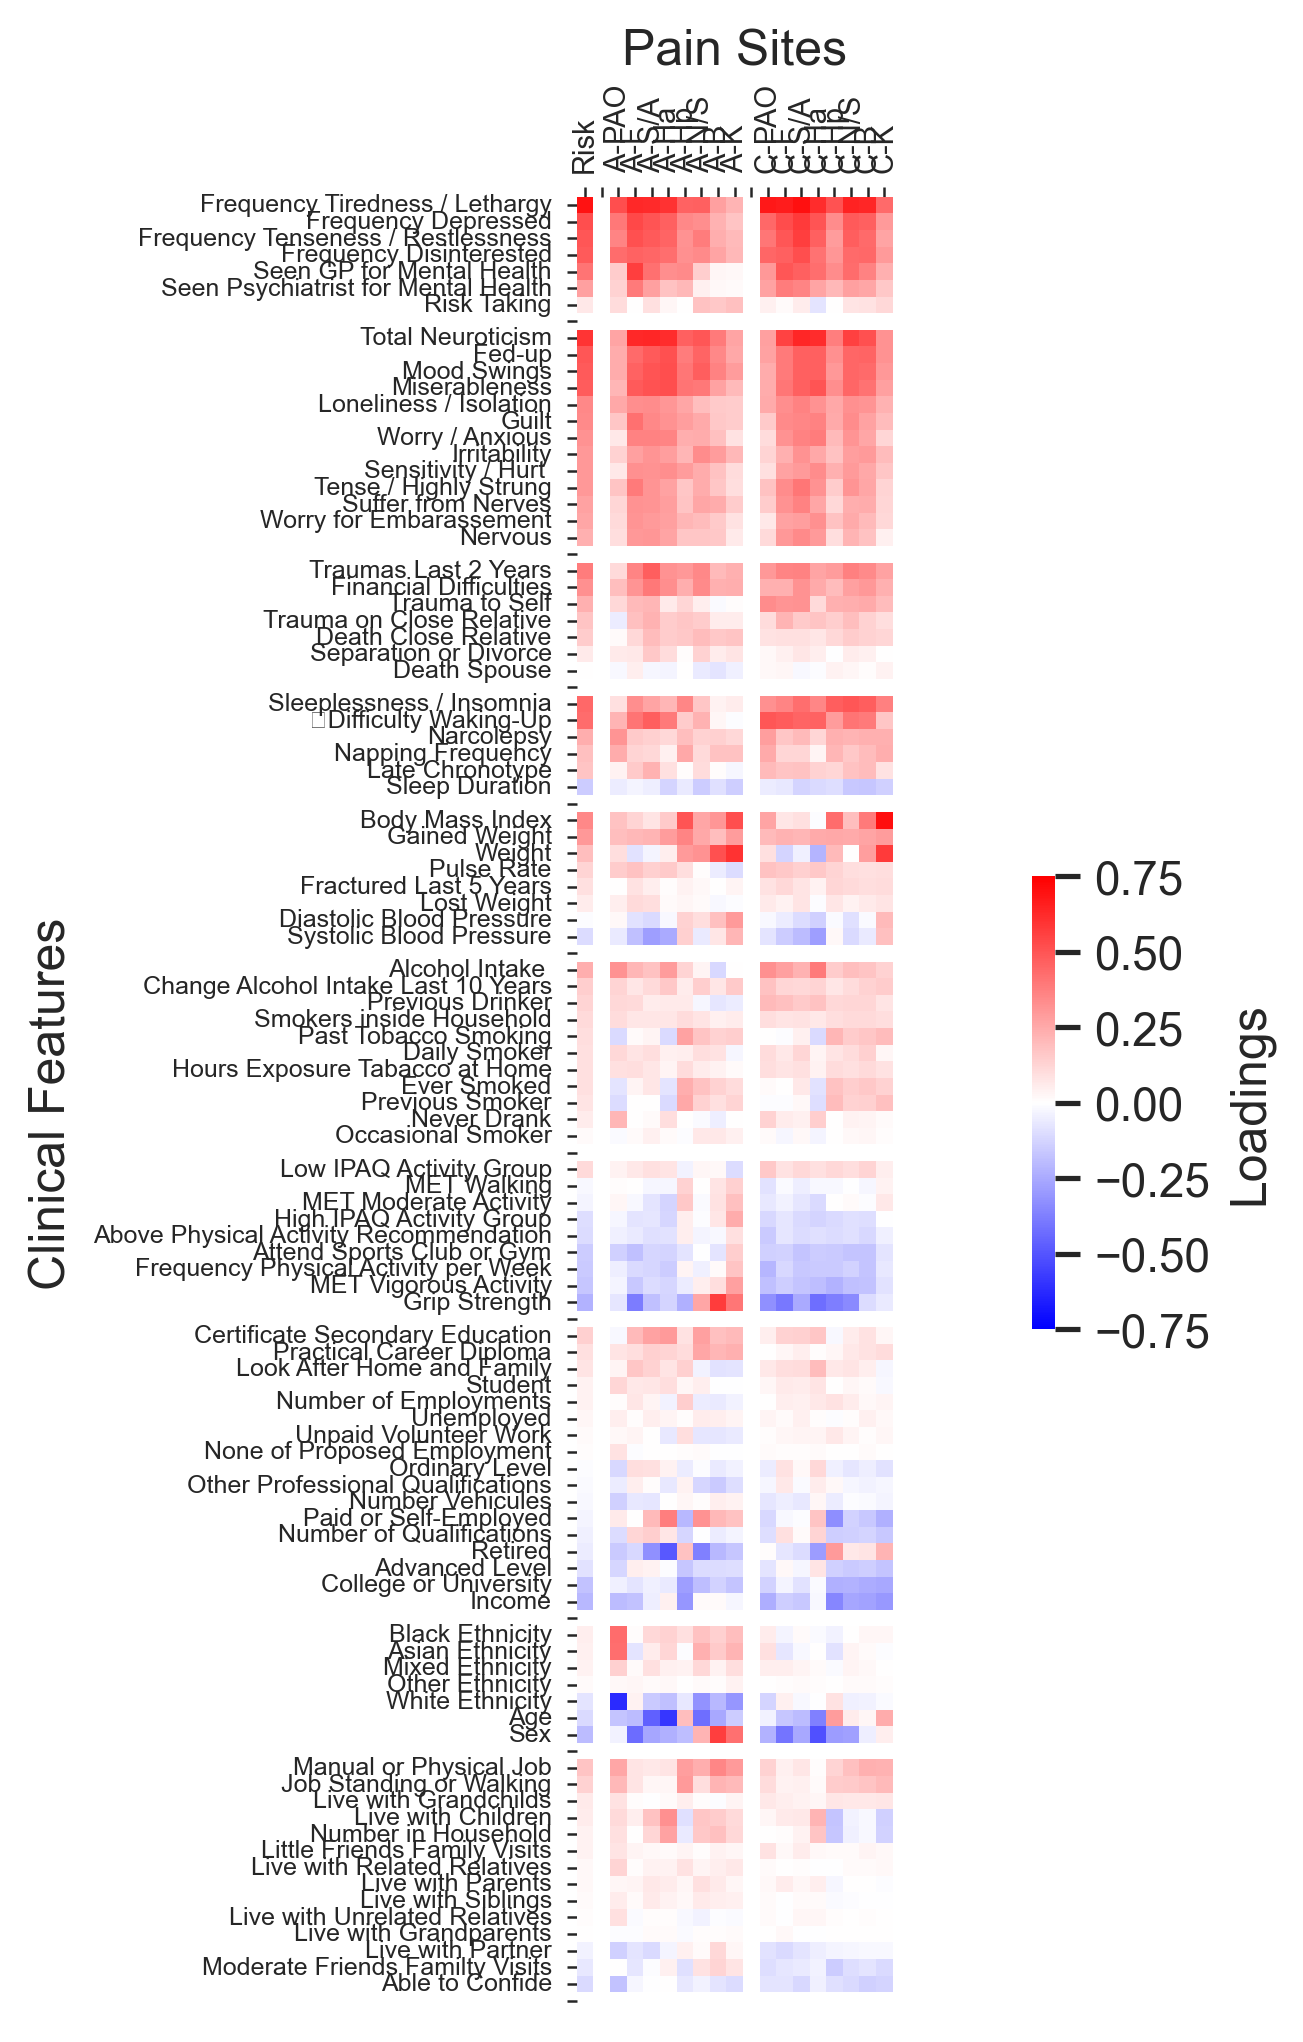

In [11]:
#### FIGURE A. Heatmap of Loadings ####
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
sns.heatmap(data = Loadings_vis, cbar = True, square = True, vmax = 0.75, vmin = -0.75, cmap = 'bwr', center = 0,  yticklabels=True, cbar_kws =  {'use_gridspec': False, 'location': 'top', 'label': 'Loadings', 'ticks' : [-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75], 'use_gridspec':False, 'location':'right', 'shrink':0.25})
axs.xaxis.tick_top(), axs.xaxis.set_label_position('top'), axs.xaxis.tick_top()
axs.set_xticklabels(axs.get_xticklabels(), fontsize = 7, rotation = 90)
axs.set_yticklabels(axs.get_yticklabels(), fontsize = 6), axs.tick_params(left=True)
axs.tick_params(width = 0.6, length = 2.5)

In [12]:
# Compute AUC-ROC Curves for each model on the pain sites they were derived on
Test_PF = preproc_UKB_Test[preproc_UKB_Test['NoPainLastMonth_T0']==1]
list_AUC = [[],[]]

for i in P_Ord[1:]: #Iterate for pain site
    df = preproc_UKB_Test[preproc_UKB_Test[dico_rename[i]]==1].append(Test_PF)
    Y_Test, Y_Pred = df[dico_rename[i]], np.dot(df[variables_T0], CandidatModels_W[i])
    fpr, tpr, _ = metrics.roc_curve(y_true = Y_Test, y_score = Y_Pred)
    list_AUC[0].append(fpr), list_AUC[1].append(tpr)

#List of AUC-ROC for CP and AP
AUC_Test = pd.Series(data = [metrics.auc(list_AUC[0][i], list_AUC[1][i]) for i in range(16)], name = 'AUC-ROC', index = P_Ord[1:])
AUC_Test = pd.DataFrame({'Acute': AUC_Test.filter(like='A-',axis=0).values,'Chronic': AUC_Test.filter(like='C-', axis=0).values}, index = Sites2)

In [13]:
# Correlations of Models with Number of Pain Sites
F_WP = preproc_UKB_Test.WidespreadPainLastMonth_T0!=1
X_Test_F, Y_Test_F = preproc_UKB_Test[F_WP][variables_T0], preproc_UKB_Test[F_WP].NumberPainTypesLastMonth_T0
CORR = pd.Series(index = P_Ord)
Models = pd.DataFrame(columns = P_Ord, index = X_Test_F.index)
for i in P_Ord: #Iterate for pain site
    Models[i] = stats.zscore(np.dot(X_Test_F, CandidatModels_W[i]))
    CORR[i] = stats.pearsonr(Models[i], Y_Test_F)[0]
A = pd.DataFrame({'Acute':CORR.Risk, 'Chronic':CORR.Risk}, index = ['Risk'])
B = pd.DataFrame({'Acute': CORR.filter(like='A-',axis=0).values,'Chronic': CORR.filter(like='C-', axis=0).values}, index = Sites2)
CORR_Test = pd.concat((A, B))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


In [14]:
CORR_Test

,Acute,Chronic
Risk,0.373007,0.373007
PAO,0.221886,0.313733
F,0.329489,0.326394
S/A,0.321611,0.351429
Ha,0.300596,0.299391
Hp,0.298419,0.297218
N/S,0.259767,0.350486
B,0.171016,0.355593
K,0.170319,0.285374


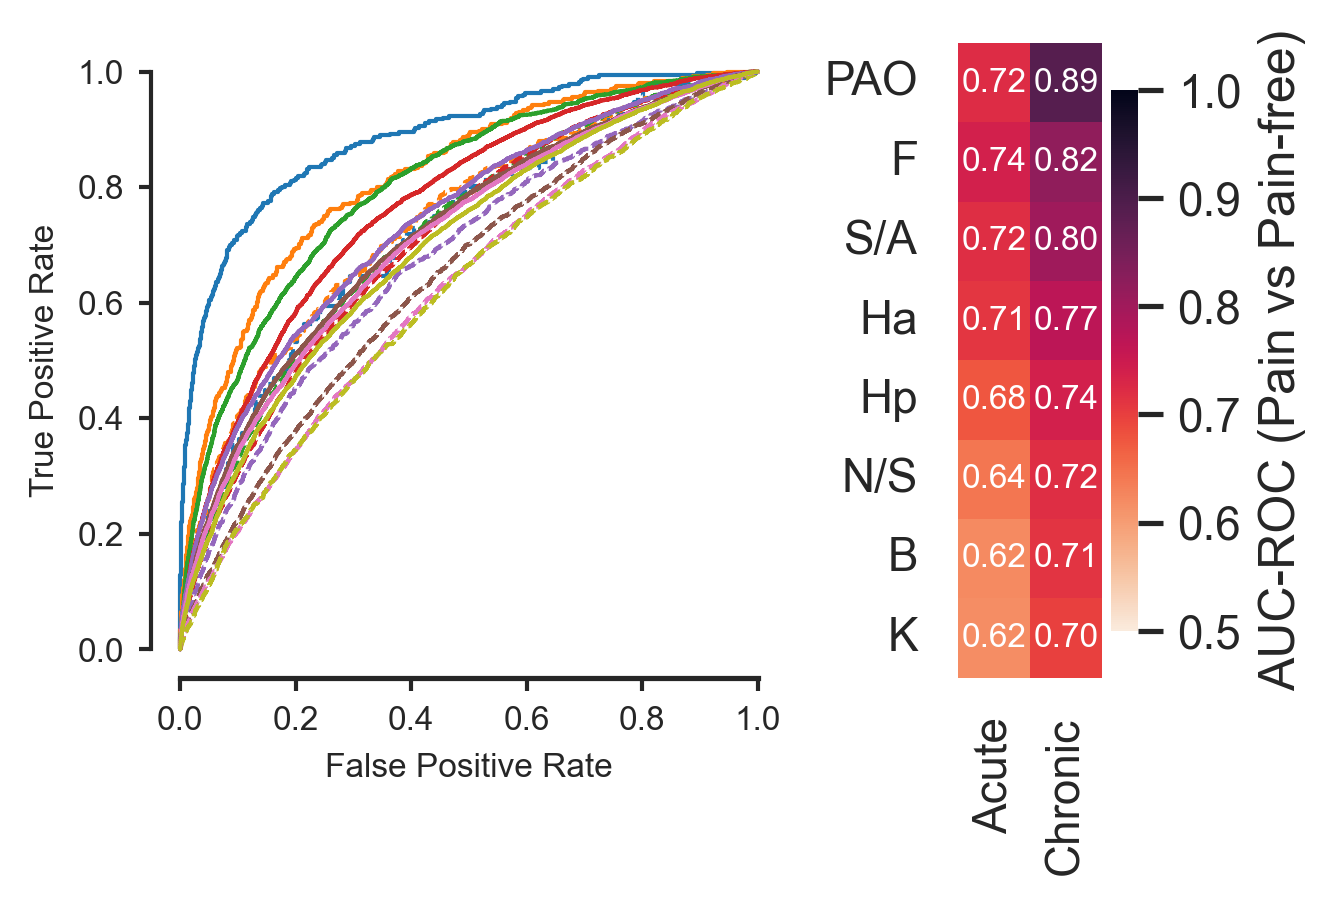

In [15]:
#### FIGURE B1. AUC-ROC Curves of Candidat Models on Test Data ####
col = sns.color_palette("tab10", 9)
col.pop(7)
plt.rcParams['font.size'], fs = 8, 8
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(4.5,3), gridspec_kw={'width_ratios': [2, 0.5]})
#AUC-ROC Curves
for i in range(8): axs[0].plot(list_AUC[0][i], list_AUC[1][i], ls = '--', lw = 1, color = col[i])
for i in range(8): axs[0].plot(list_AUC[0][i+8], list_AUC[1][i+8], ls = '-', lw = 1, color = col[i])
axs[0].set_aspect(1)
axs[0].tick_params(bottom=True, left=True, length=3, width=1)
axs[0].spines[['top', 'right']].set_visible(False), axs[0].spines[['left', 'bottom']].set_bounds((0, 1))
axs[0].set_ylabel('True Positive Rate', fontsize = fs), axs[0].set_xlabel('False Positive Rate', fontsize = fs)
axs[0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]), axs[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axs[0].set_xticklabels(axs[0].get_xticks(), fontsize = fs), axs[0].set_yticklabels(axs[0].get_yticks(), fontsize = fs)
axs[0].spines[['top', 'left']].set_linewidth(1)
# AUC HeatMaps
sns.heatmap(ax = axs[1], data = AUC_Test, annot=True, fmt=".2f", cmap = 'rocket_r', square = True, vmin = 0.5, vmax = 1.0, annot_kws={"fontsize": 8}, cbar = True, cbar_kws =  {'label': 'AUC-ROC (Pain vs Pain-free)'})
axs[1].set_aspect(1.1)
axs[1].set_yticklabels(Sites2, rotation = 0)
fig.tight_layout()

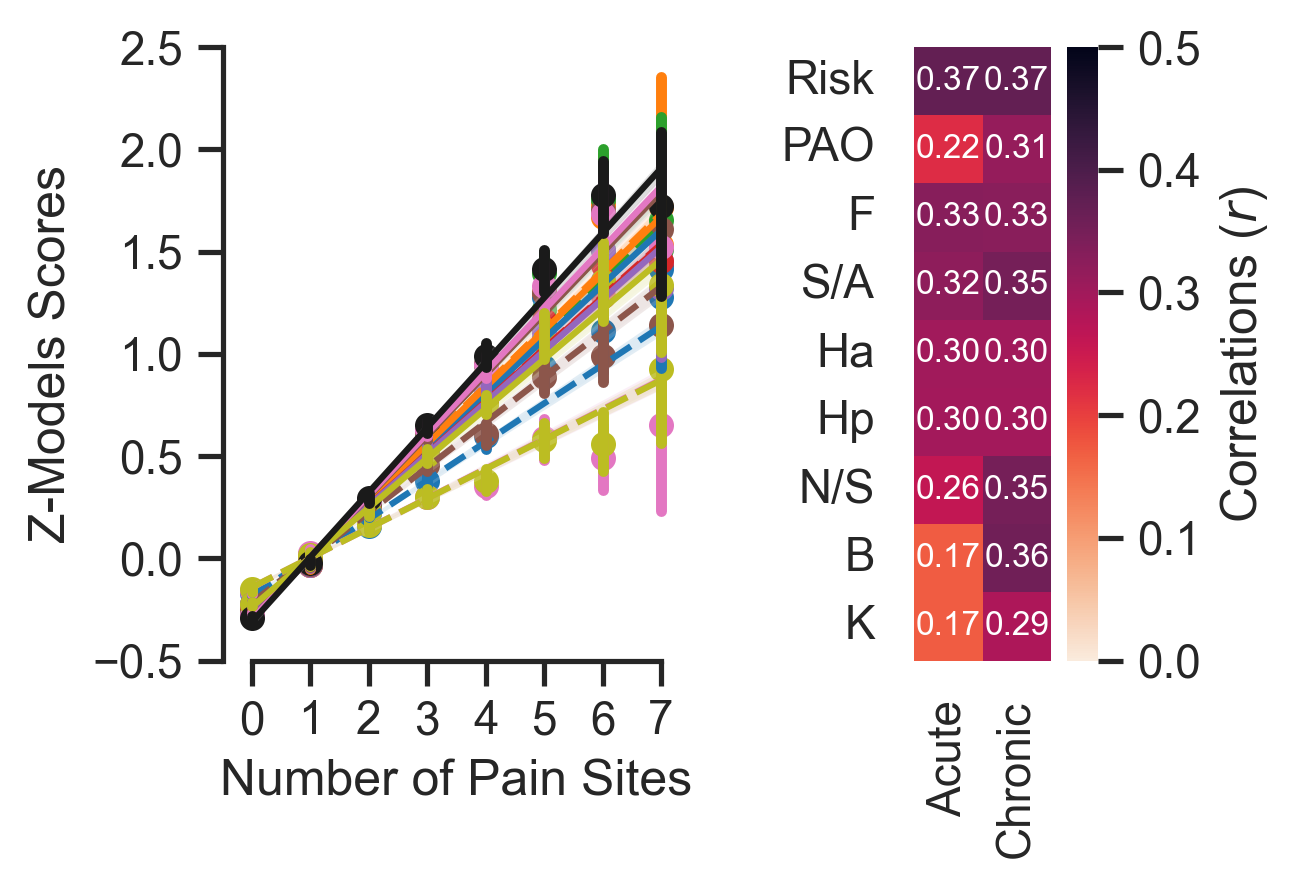

In [36]:
 #### FIGURE B1. Correlations with Number of Pain Sites of Candidat Models on Test Data ####
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(4.5,3), gridspec_kw={'width_ratios': [2, 1]})
#Reg plot Curves
for i in range(8): sns.regplot(ax = axs[0], x = Y_Test_F, y = Models[P_Ord[1:][i]], color = col[i], x_estimator=np.mean, line_kws={'linestyle':'--', 'lw': 1.5}, n_boot = 100, scatter_kws={"s": 25})
for i in range(8): sns.regplot(ax = axs[0], x = Y_Test_F, y = Models[P_Ord[1:][i+8]], color = col[i], x_estimator=np.mean, line_kws={'linestyle':'-', 'lw': 1.5}, n_boot = 100, scatter_kws={"s": 25})
sns.regplot(ax = axs[0], x = Y_Test_F, y = Models['Risk'], color = 'k', x_estimator=np.mean, line_kws={'linestyle':'-', 'lw': 1.5}, n_boot = 100, scatter_kws={"s": 25})
axs[0].set_aspect(3.5)
axs[0].tick_params(bottom=True, left=True)
axs[0].set_xticks([0,1,2,3,4,5,6,7]), axs[0].set_xlim(-0.5, 7.5), axs[0].set_xlabel('Number of Pain Sites')
axs[0].spines[['top', 'right']].set_visible(False), axs[0].spines['bottom'].set_bounds((0, 7))
axs[0].spines['left'].set_bounds((-0.5, 2.5)), axs[0].set_ylim(-0.5, 2.5), axs[0].set_ylabel('Z-Models Scores')
# Heatmap of Correlations
sns.heatmap(ax = axs[1], data = CORR_Test, annot=True, fmt=".2f", annot_kws={"fontsize": 8}, cmap = 'rocket_r', square = True, yticklabels=True, vmin = 0, vmax = 0.5, cbar = True, cbar_kws =  {'label': 'Correlations ($r$)'})
fig.tight_layout()

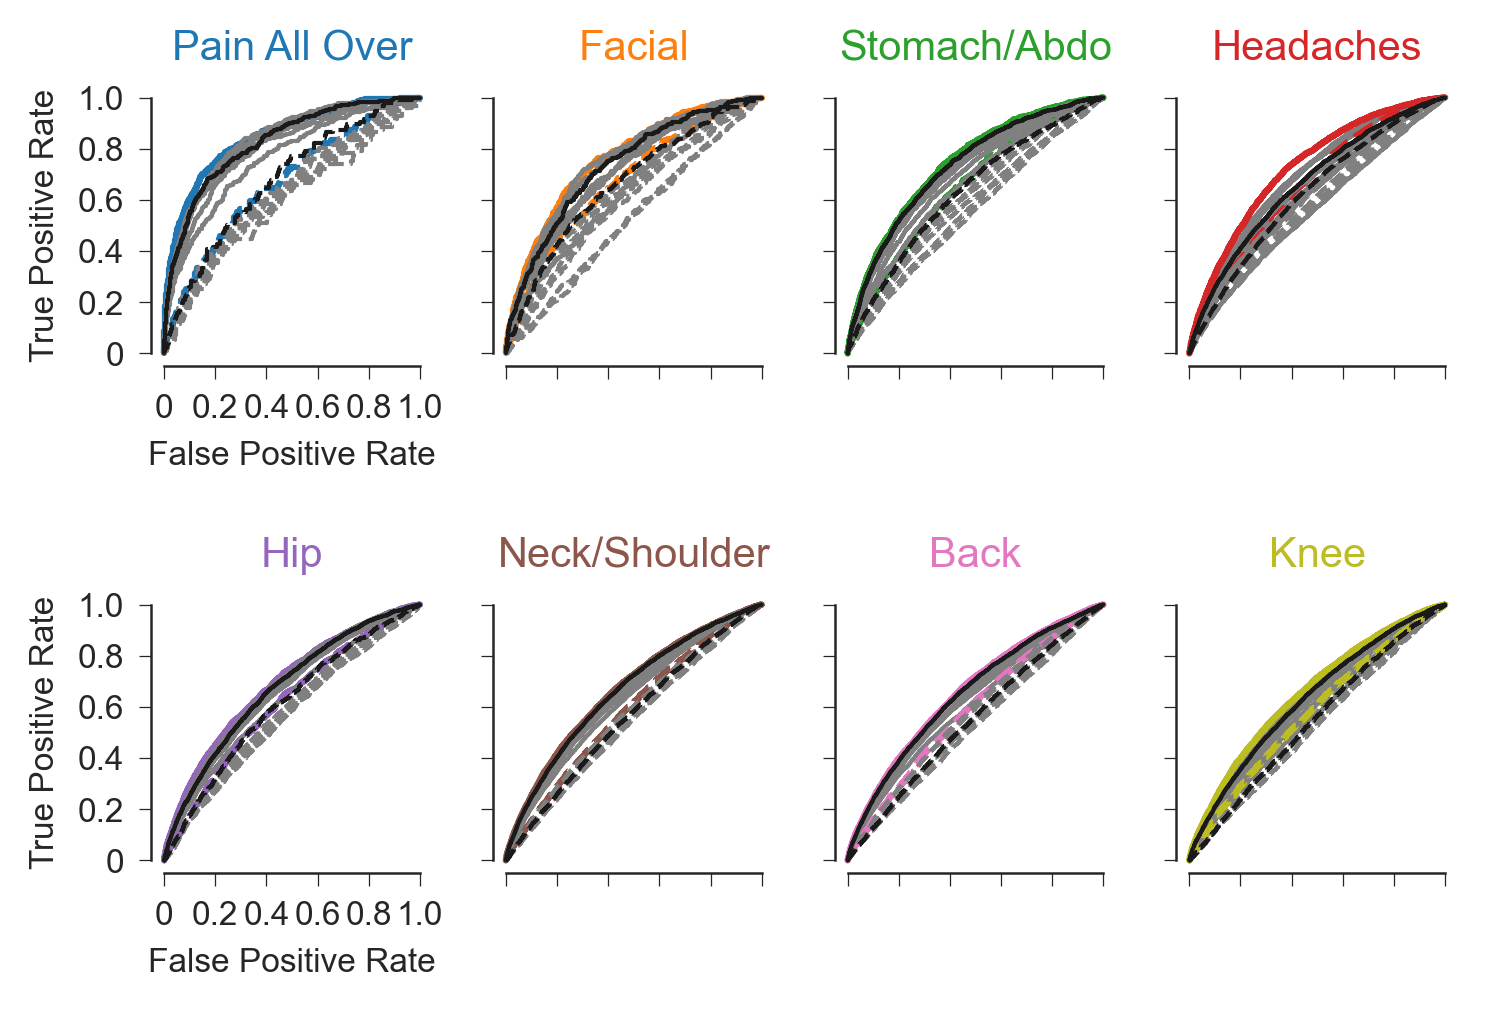

In [38]:
##### FIGURE C.1. Plotting CROSS-SECTIONAL (One Site vs All-Else) ####
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(5,3.5))
dico_rename2 = {v: k for k, v in dico_rename.items()}
col_pal = sns.color_palette("tab10", 9)
col_pal.pop(7)
#Upper two rows are for Cross-Sectional
for idx, (ap,cp) in enumerate(zip(AP_T0, CP_T0)):
        if idx > 3: row, col = 1, idx - 4
        else: row, col = 0, idx
        for idx2, (ap2, cp2) in enumerate(zip(AP_T0, CP_T0)):
                if idx == idx2: color_line, lt = col_pal[idx2], 1.5
                else: color_line, lt = 'grey', 1
                ypred_ap, ypred_cp = np.dot(X_Test, CandidatModels_W[dico_rename2[ap2]]), np.dot(X_Test, CandidatModels_W[dico_rename2[cp2]])
                fpr, tpr, _ = metrics.roc_curve(y_true = preproc_UKB_Test[ap], y_score = ypred_ap)
                axs[row,col].plot(fpr, tpr, ls = '--', color = color_line, linewidth = lt)
                fpr, tpr, _ = metrics.roc_curve(y_true = preproc_UKB_Test[cp], y_score = ypred_cp)
                axs[row,col].plot(fpr, tpr, ls = '-', color = color_line, linewidth = lt)
        fpr, tpr, _ = metrics.roc_curve(y_true = preproc_UKB_Test[ap], y_score = preproc_UKB_Test.PLS)
        axs[row,col].plot(fpr, tpr, ls = '--', color = 'k', linewidth = 1)
        fpr, tpr, _ = metrics.roc_curve(y_true = preproc_UKB_Test[cp], y_score = preproc_UKB_Test.PLS)
        axs[row,col].plot(fpr, tpr, ls = '-', color = 'k', linewidth = 1)
        axs[row, col].set_title(Sites1[idx], color = col_pal[idx], fontsize = 10)
        axs[row, col].set_aspect('equal')
        axs[row, col].spines[['top', 'right']].set_visible(False)
        axs[row, col].tick_params(bottom=True, left=True, width = 0.3, length = 3)
        axs[row, col].spines[['bottom', 'left']].set_bounds((0,1))
        axs[row, col].spines[['bottom', 'left']].set_linewidth(0.6)
        if col==0 and (row==0 or row==1): #Making the axes for the first figure labeled
                axs[row, col].set_xticks(np.arange(0, 1.2, 0.2)), axs[row, col].set_yticks(np.arange(0, 1.2, 0.2))
                axs[row, col].set_xlabel('False Positive Rate', fontsize = fs), axs[row, col].set_ylabel('True Positive Rate', fontsize = fs)
                axs[row, col].set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize = fs), axs[row, col].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize = fs)
        else: 
                axs[row, col].set_xticks(np.arange(0, 1.2, 0.2)), axs[row, col].set_yticks(np.arange(0, 1.2, 0.2))
                axs[row, col].set_xticklabels([]), axs[row, col].set_yticklabels([])
fig.tight_layout()

In [39]:
# Computing the AUC-ROC for each combination of applied and examined models of pain sites
AUC_CP_BL, AUC_AP_BL = np.zeros((8,8)), np.zeros((8,8)) 
for idx1, (ap, cp) in enumerate(zip(AP_T0, CP_T0)):
    ypred_ap, ypred_cp = np.dot(X_Test, CandidatModels_W[dico_rename2[ap]]), np.dot(X_Test, CandidatModels_W[dico_rename2[cp]])
    for idx2, (ap2, cp2) in enumerate(zip(AP_T0, CP_T0)):
        y_ap, y_cp = preproc_UKB_Test[ap2].values, preproc_UKB_Test[cp2].values
        AUC_CP_BL[idx1, idx2] = metrics.roc_auc_score(y_true = y_cp, y_score = ypred_cp)
        AUC_AP_BL[idx1, idx2] = metrics.roc_auc_score(y_true = y_ap, y_score = ypred_ap)
AUC_AP_BL = pd.DataFrame(data = AUC_AP_BL.T, columns = [i + ' >' for i in Sites2], index = [i + ' <' for i in Sites2])
AUC_CP_BL = pd.DataFrame(data = AUC_CP_BL.T, columns = [i + ' >' for i in Sites2], index = [i + ' <' for i in Sites2])

#Add AUC-ROC from Risk Score
AUC_AP_model, AUC_CP_model = [], []
for idx, i in enumerate(AP_T0): AUC_AP_model.append(metrics.roc_auc_score(y_score = preproc_UKB_Test.PLS, y_true = preproc_UKB_Test[i]))
for idx, i in enumerate(CP_T0): AUC_CP_model.append(metrics.roc_auc_score(y_score = preproc_UKB_Test.PLS, y_true = preproc_UKB_Test[i]))
# Add AUCs from the model as the first column
AUC_AP_BL.insert(0, "RM >", np.asarray(AUC_AP_model))
AUC_CP_BL.insert(0, "RM >", np.asarray(AUC_CP_model))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


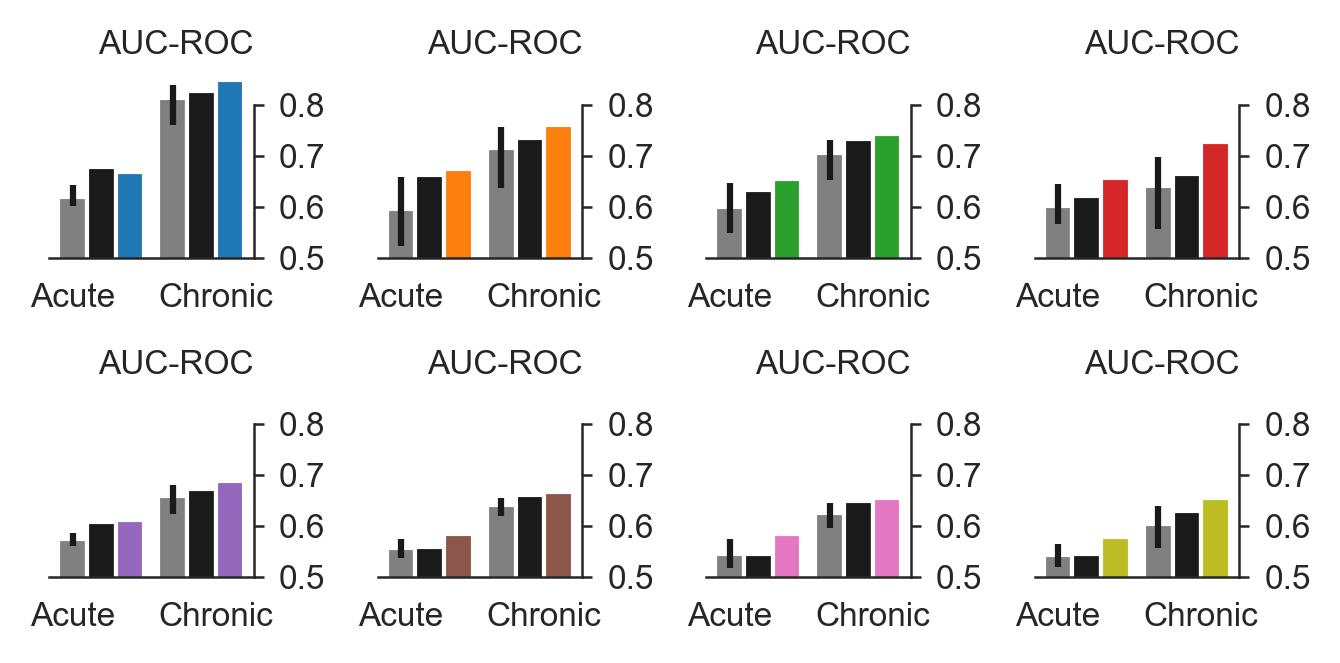

In [40]:
##### FIGURE C.2. Plotting CROSS-SECTIONAL Bar plots (One Site vs All-Else) ####
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(4.5,2.25))
AR = [0, 1, 2, 3.5, 4.5, 5.5]
for idx in range(8):
        if idx > 3: row, col = 1, idx - 4
        else: row, col = 0, idx
        ap_1, ap_2, cp_1, cp_2  = AUC_AP_BL.drop(columns = 'RM >'), AUC_AP_BL['RM >'], AUC_CP_BL.drop(columns = 'RM >'), AUC_CP_BL['RM >']
        height = [np.mean(np.delete(ap_1.values[idx], idx)),    ap_2.values[idx],    ap_1.values[idx, idx],    np.mean(np.delete(cp_1.values[idx], idx)),    cp_2.values[idx], cp_1.values[idx, idx]]
        err = [[height[0] - np.min(np.delete(ap_1.values[idx], idx)), 0, 0,    height[3] - np.min(np.delete(cp_1.values[idx], idx)), 0, 0], [np.max(np.delete(ap_1.values[idx], idx)) - height[0], 0, 0,    np.max(np.delete(cp_1.values[idx], idx)) - height[3], 0, 0]]
        axs[row,col].bar(AR, height, width = 1, color = ['grey', 'k', col_pal[idx], 'grey', 'k', col_pal[idx]])
        axs[row,col].errorbar(AR, height, yerr=err, fmt='none', color='k')
        ### FINISH BAR PLOTTING
        axs[row,col].set_title('AUC-ROC', loc='right', fontsize = fs),
        axs[row,col].set_ylim((0.5, 0.85)), axs[row,col].set_yticks(np.arange(0.5, 0.8, 0.1))
        axs[row,col].set_yticklabels([0.5, 0.6, 0.7, 0.8], fontsize = fs)
        axs[row,col].set_xticklabels(['', 'Acute', 'Chronic', ''], fontsize = fs)
        axs[row,col].yaxis.tick_right(), axs[row, col].spines[['right']].set_bounds((0.5,0.8))
        axs[row,col].spines[['top', 'left']].set_visible(False), axs[row,col].spines[['bottom', 'right']].set_linewidth(0.6)
        axs[row,col].tick_params(width = 0.6, length = 2.5)
fig.tight_layout()

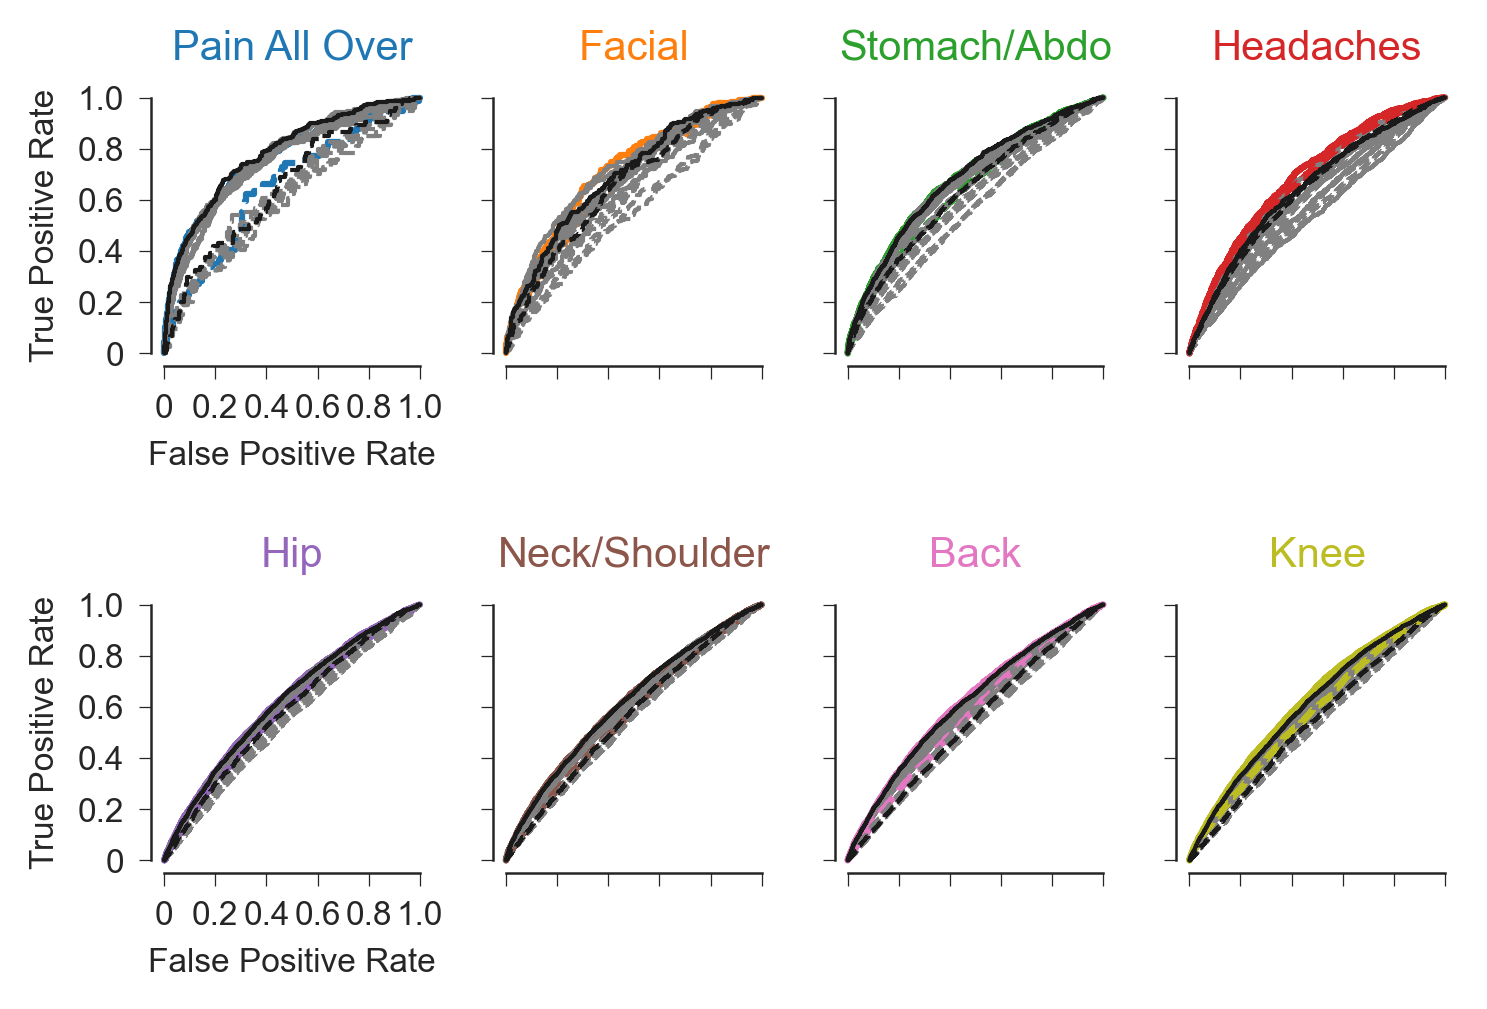

In [41]:
##### FIGURE C.3. Plotting LONGITUDINAL (One Site vs All-Else) ####
dico_rename2 = {v: k for k, v in dico_rename.items()}
col_pal = sns.color_palette("tab10", 9)
col_pal.pop(7)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(5,3.5))
#Upper two rows are for Cross-Sectional
for idx, (ap,cp) in enumerate(zip(AP_T0, CP_T0)):
        if idx > 3: row, col = 1, idx - 4
        else: row, col = 0, idx
        F_ap, F_cp = UKB_T2[ap] == 0, UKB_T2[cp] == 0
        for idx2, (ap2, cp2) in enumerate(zip(AP_T0, CP_T0)):
                if idx == idx2: color_line, lt = col_pal[idx2], 1.5
                else: color_line, lt = 'grey', 1
                ypred_ap, ypred_cp = np.dot(UKB_T2[F_ap][variables_T0], CandidatModels_W[dico_rename2[ap2]]), np.dot(UKB_T2[F_cp][variables_T0], CandidatModels_W[dico_rename2[cp2]])
                fpr, tpr, _ = metrics.roc_curve(y_true = UKB_B[F_ap][ap[:-2] + 'T2'], y_score = ypred_ap)
                axs[row,col].plot(fpr, tpr, ls = '--', color = color_line, linewidth = lt)
                fpr, tpr, _ = metrics.roc_curve(y_true = UKB_B[F_cp][cp[:-2] + 'T2'], y_score = ypred_cp)
                axs[row,col].plot(fpr, tpr, ls = '-', color = color_line, linewidth = lt)
        fpr, tpr, _ = metrics.roc_curve(y_true = UKB_B[F_ap][ap[:-2]+'T2'], y_score = UKB_T2[F_ap].PLS)
        axs[row,col].plot(fpr, tpr, ls = '--', color = 'k', linewidth = 1)
        fpr, tpr, _ = metrics.roc_curve(y_true = UKB_B[F_cp][cp[:-2]+'T2'], y_score = UKB_T2[F_cp].PLS)
        axs[row,col].plot(fpr, tpr, ls = '-', color = 'k', linewidth = 1)
        axs[row, col].set_title(Sites1[idx], color = col_pal[idx], fontsize = 10)
        axs[row, col].set_aspect('equal')
        axs[row, col].spines[['top', 'right']].set_visible(False)
        axs[row, col].tick_params(bottom=True, left=True, width = 0.3, length = 3)
        axs[row, col].spines[['bottom', 'left']].set_bounds((0,1))
        axs[row, col].spines[['bottom', 'left']].set_linewidth(0.6)
        if col==0 and (row==0 or row==1): #Making the axes for the first figure labeled
                axs[row, col].set_xticks(np.arange(0, 1.2, 0.2)), axs[row, col].set_yticks(np.arange(0, 1.2, 0.2))
                axs[row, col].set_xlabel('False Positive Rate', fontsize = fs), axs[row, col].set_ylabel('True Positive Rate', fontsize = fs)
                axs[row, col].set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize = fs), axs[row, col].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize = fs)
        else: 
                axs[row, col].set_xticks(np.arange(0, 1.2, 0.2)), axs[row, col].set_yticks(np.arange(0, 1.2, 0.2))
                axs[row, col].set_xticklabels([]), axs[row, col].set_yticklabels([])
fig.tight_layout()

In [42]:
# [Longitudinal] Computing the AUC-ROC for each combination of applied and examined models of pain sites
AUC_CP_FU, AUC_AP_FU = np.zeros((8,8)), np.zeros((8,8)) 
for idx1, (ap, cp) in enumerate(zip(AP_T0, CP_T0)):
    F_ap, F_cp = UKB_T2[ap] == 0, UKB_T2[cp] == 0
    ypred_ap, ypred_cp = np.dot(UKB_T2[variables_T0], CandidatModels_W[dico_rename2[ap]]), np.dot(UKB_T2[variables_T0], CandidatModels_W[dico_rename2[cp]])
    for idx2, (ap2, cp2) in enumerate(zip(AP_T2, CP_T2)):
        y_ap, y_cp = UKB_B[F_ap][ap2].values, UKB_B[F_cp][cp2].values
        AUC_AP_FU[idx1, idx2] = metrics.roc_auc_score(y_true = y_ap, y_score = ypred_ap[F_ap])
        AUC_CP_FU[idx1, idx2] = metrics.roc_auc_score(y_true = y_cp, y_score = ypred_cp[F_cp])
AUC_AP_FU = pd.DataFrame(data = AUC_AP_FU.T, columns = [i + ' >' for i in Sites2], index = [i + ' <' for i in Sites2])
AUC_CP_FU = pd.DataFrame(data = AUC_CP_FU.T, columns = [i + ' >' for i in Sites2], index = [i + ' <' for i in Sites2])

#Add AUC-ROC from Risk Score
AUC_AP_model, AUC_CP_model = [], []
for idx, (i,j) in enumerate(zip(AP_T0, CP_T0)): 
    F_ap, F_cp = UKB_T2[i] == 0, UKB_T2[j] == 0
    AUC_AP_model.append(metrics.roc_auc_score(y_score = UKB_T2[F_ap].PLS, y_true = UKB_B[F_ap][i[:-2] + 'T2']))
    AUC_CP_model.append(metrics.roc_auc_score(y_score = UKB_T2[F_cp].PLS, y_true = UKB_B[F_cp][j[:-2] + 'T2']))
# Add AUCs from the model as the first column
AUC_AP_FU.insert(0, "RM >", np.asarray(AUC_AP_model))
AUC_CP_FU.insert(0, "RM >", np.asarray(AUC_CP_model))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


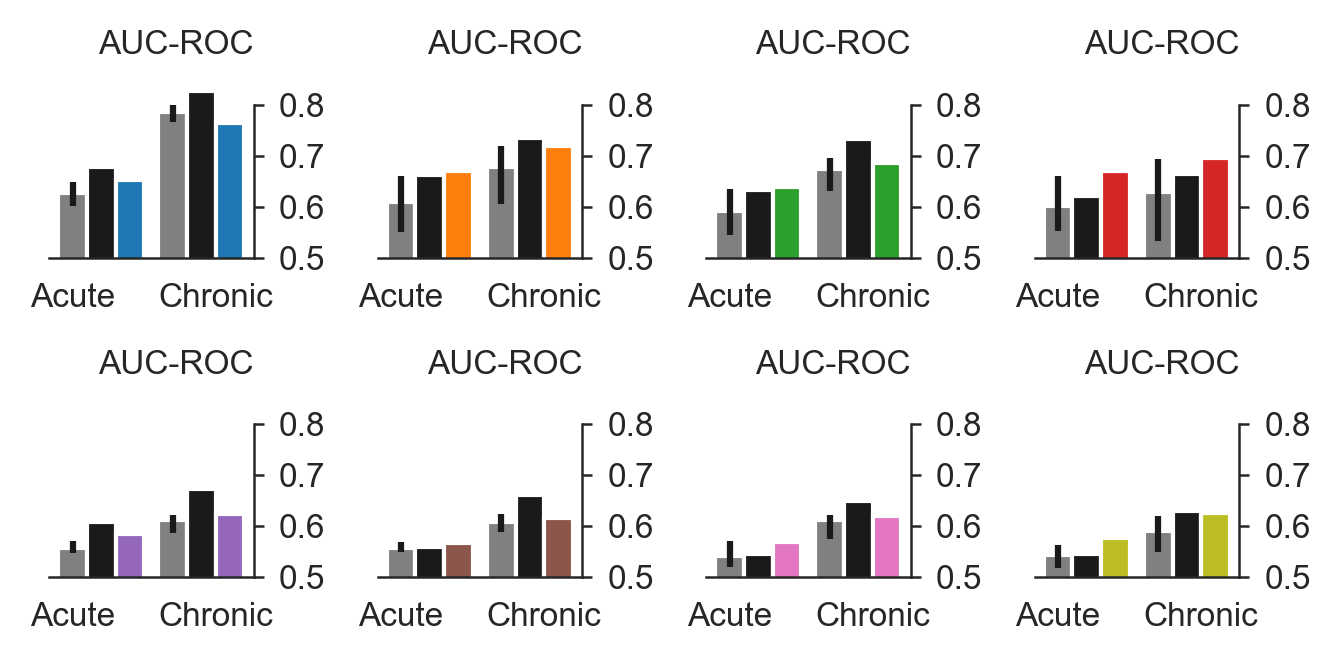

In [43]:
##### FIGURE C.4. Plotting LONGITUDINAL Bar plots (One Site vs All-Else) ####
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(4.5,2.25))
AR = [0, 1, 2, 3.5, 4.5, 5.5]
for idx in range(8):
        if idx > 3: row, col = 1, idx - 4
        else: row, col = 0, idx
        ap_1, ap_2, cp_1, cp_2  = AUC_AP_FU.drop(columns = 'RM >'), AUC_AP_BL['RM >'], AUC_CP_FU.drop(columns = 'RM >'), AUC_CP_BL['RM >']
        height = [np.mean(np.delete(ap_1.values[idx], idx)),    ap_2.values[idx],    ap_1.values[idx, idx],    np.mean(np.delete(cp_1.values[idx], idx)),    cp_2.values[idx], cp_1.values[idx, idx]]
        err = [[height[0] - np.min(np.delete(ap_1.values[idx], idx)), 0, 0,    height[3] - np.min(np.delete(cp_1.values[idx], idx)), 0, 0], [np.max(np.delete(ap_1.values[idx], idx)) - height[0], 0, 0,    np.max(np.delete(cp_1.values[idx], idx)) - height[3], 0, 0]]
        axs[row,col].bar(AR, height, width = 1, color = ['grey', 'k', col_pal[idx], 'grey', 'k', col_pal[idx]])
        axs[row,col].errorbar(AR, height, yerr=err, fmt='none', color='k')
        ### FINISH BAR PLOTTING
        axs[row,col].set_title('AUC-ROC', loc='right', fontsize = fs),
        axs[row,col].set_ylim((0.5, 0.85)), axs[row,col].set_yticks(np.arange(0.5, 0.8, 0.1))
        axs[row,col].set_yticklabels([0.5, 0.6, 0.7, 0.8], fontsize = fs)
        axs[row,col].set_xticklabels(['', 'Acute', 'Chronic', ''], fontsize = fs)
        axs[row,col].yaxis.tick_right(), axs[row, col].spines[['right']].set_bounds((0.5,0.8))
        axs[row,col].spines[['top', 'left']].set_visible(False), axs[row,col].spines[['bottom', 'right']].set_linewidth(0.6)
        axs[row,col].tick_params(width = 0.6, length = 2.5)
fig.tight_layout()

In [44]:
# Ordering from top to bottom
S1 = ['Headaches','Facial','Neck/Shoulder','Stomach/Abdo','Back','Hip','Knee'] # Long Labels
S2 = ['Ha', 'F', 'N/S', 'S/A', 'B', 'Hp', 'K'] #Short labels
P2 = ['Headaches','FacialPain','NeckShoulderPain','StomachAbdominalPain','BackPain','HipPain','KneePain']

# Correlation across Loadings and Distance Between Pain Sites
Mat_AP_Sim, Mat_CP_Sim = Loadings[['Risk', 'A-PAO']+['A-'+i for i in S2]].corr(), Loadings[['Risk', 'C-PAO']+['C-'+i for i in S2]].corr()


# Obtain distance vector
dist, dist_mat = np.arange(7), np.zeros((7,7))
for idx1 in range(7): # For loop
    for idx2 in range(7):
            dist_mat[idx1, idx2] = abs(dist[idx1] - dist[idx2])

# Vectorize distance
mask = np.triu_indices(7, k = 1) #Without diagonal
D = dist_mat[mask] #Without diagonal
D_AP_Sim, D_CP_Sim = np.arctanh(Mat_AP_Sim.values[2:, 2:][mask]), np.arctanh(Mat_CP_Sim.values[2:, 2:][mask])

#Permutation Correlations
perm_AP_Sim, perm_CP_Sim = nltools.stats.correlation_permutation(D, D_AP_Sim, method='permute', n_permute=10000, metric='pearson', tail=2, return_perms=False, random_state=0) , nltools.stats.correlation_permutation(D, D_CP_Sim, method='permute', n_permute=10000, metric='pearson', tail=2, return_perms=False, random_state=0)


In [46]:
print('Correlations. Acute:',perm_AP_Sim['correlation']**2,'Chronic:',perm_CP_Sim['correlation']**2)
print('P-Values. Acute:',perm_AP_Sim['p'],'Chronic:',perm_CP_Sim['p'])

Correlations. Acute: 0.0905272907751439 Chronic: 0.583580915272572
P-Values. Acute: 0.1862813718628137 Chronic: 9.999000099990002e-05


In [74]:
# Boolean Mask for Visualization
Mat_AP_Sim2, Mat_CP_Sim2 = Mat_AP_Sim.copy(), Mat_CP_Sim.copy()
Mat_AP_Sim2 = Mat_AP_Sim2.rename(columns = dict(zip(Mat_AP_Sim2.index, ['Risk', 'PAO'] + S2)), index = dict(zip(Mat_AP_Sim2.index, ['Risk', 'PAO'] + S2)))
Mat_CP_Sim2 = Mat_CP_Sim2.rename(columns = dict(zip(Mat_CP_Sim2.index, ['Risk', 'PAO'] + S2)), index = dict(zip(Mat_CP_Sim2.index, ['Risk', 'PAO'] + S2)))
tril_mask, triu_mask = np.zeros_like(Mat_CP_Sim2, dtype=np.bool), np.zeros_like(Mat_CP_Sim2, dtype=np.bool)
tril_mask[np.tril_indices_from(tril_mask)], triu_mask[np.triu_indices_from(triu_mask)] = True, True

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


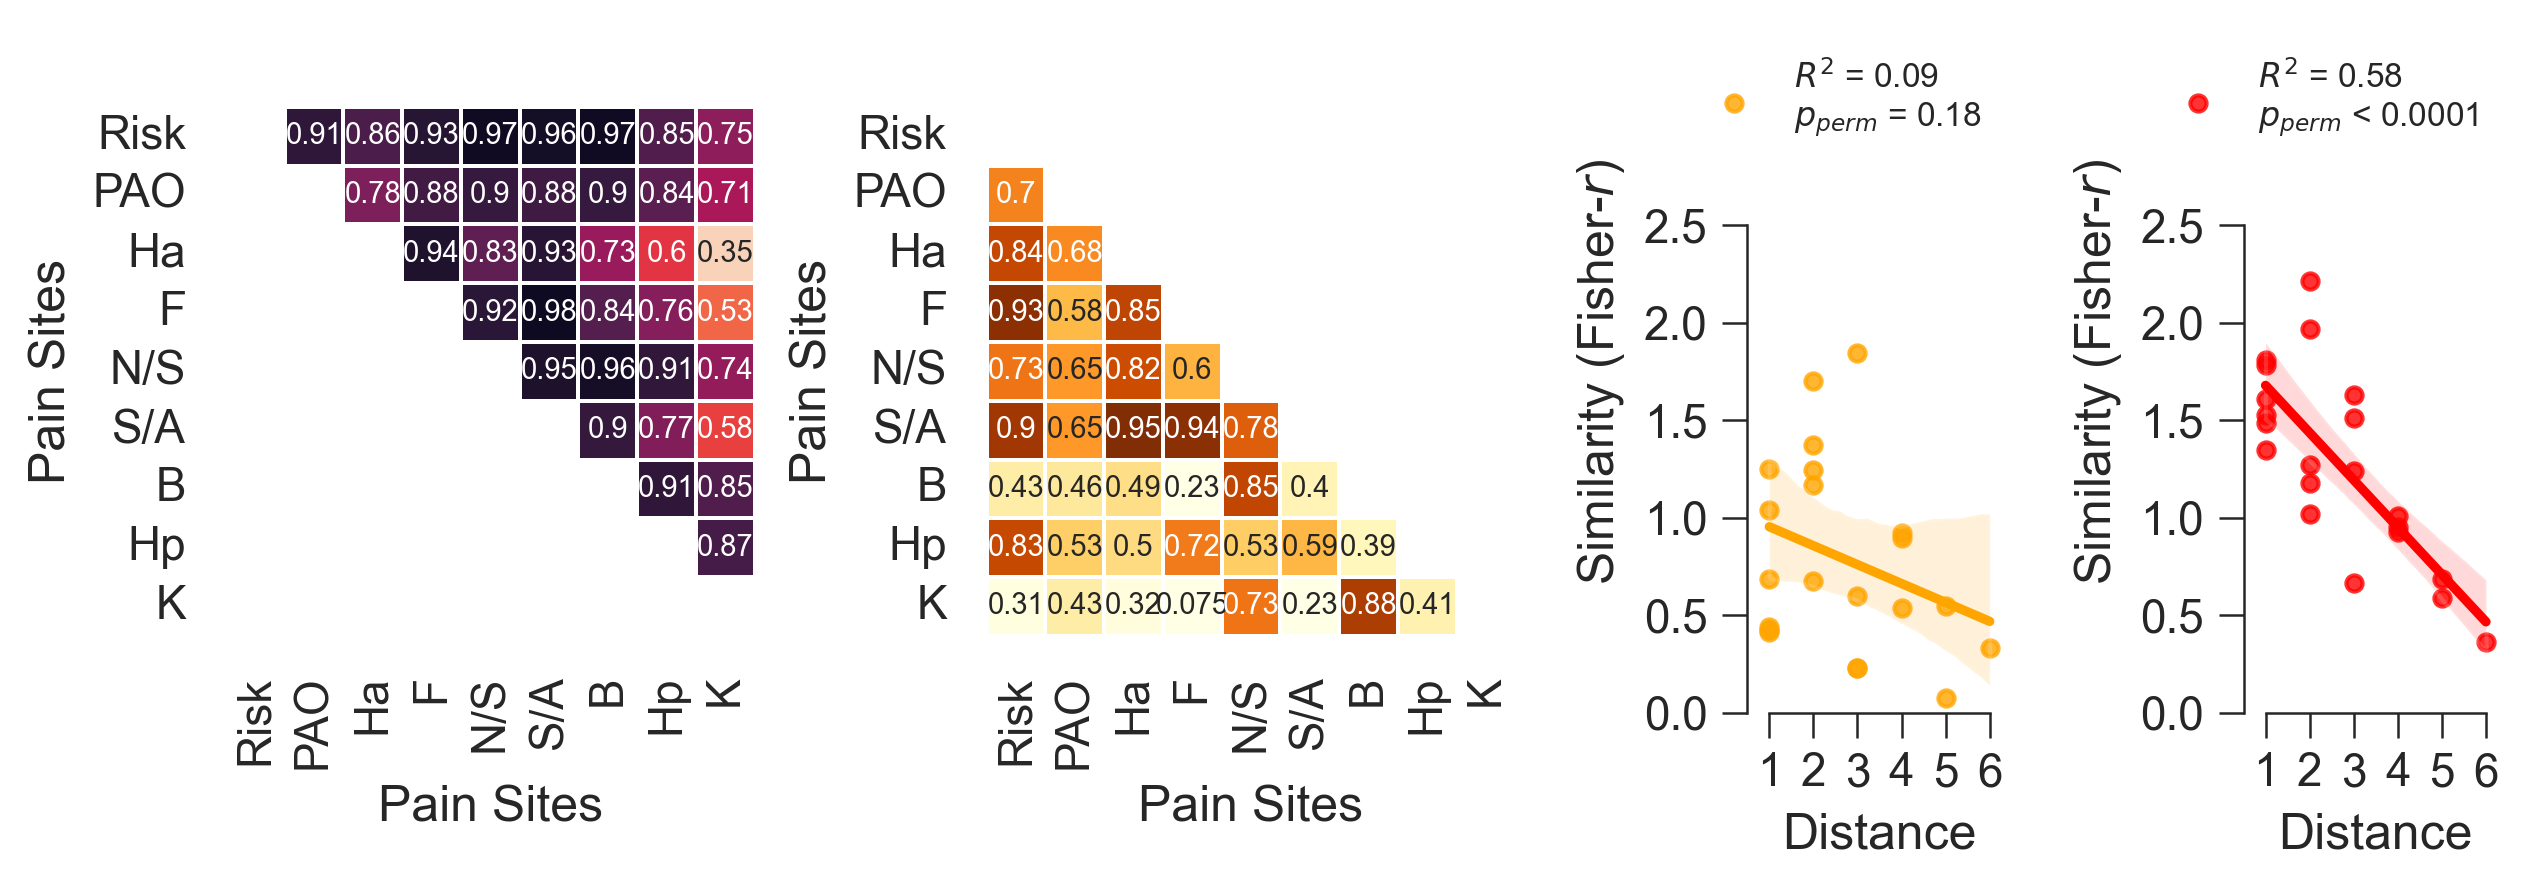

In [80]:
#### FIGURE D. Similarity Analysis between Loadings ####
fig, axs = plt.subplots(ncols=4, nrows=1,  figsize=(8.5, 3), gridspec_kw={'width_ratios': [1.5,1.5,0.75,0.75]})
# Heatmap
sns.heatmap(ax = axs[0], data = Mat_CP_Sim2, mask = tril_mask, cmap = 'rocket_r', square = True, linewidths=0.5, annot = True, cbar = False, annot_kws={"fontsize": 7}, vmin = 0.3, vmax = 1)
sns.heatmap(ax = axs[1], data = Mat_AP_Sim2, mask = triu_mask, cmap = 'YlOrBr', square = True, linewidths=0.5, annot = True, cbar = False, annot_kws={"fontsize": 7}, vmin = 0.3, vmax = 1)
#### Regplot 1
sns.regplot(ax = axs[2], x = D, y = D_AP_Sim, color = 'orange', scatter_kws={'s':15}, label = "$R^2$ = 0.09\n$p$$_{perm}$ = 0.18") 
sns.regplot(ax = axs[3], x = D, y = D_CP_Sim, color = 'Red', scatter_kws={'s':15}, label = "$R^2$ = 0.58\n$p$$_{perm}$ < 0.0001")
for i in range(2,4):
        axs[i].set_xlim(0.5, 6.5), axs[i].set_xticks(np.arange(1,7,1)), axs[i].spines['bottom'].set_bounds((1, 6)), axs[i].spines[['right', 'top']].set_visible(False), axs[i].tick_params(left=True, bottom=True)
        axs[i].set_ylabel('Similarity (Fisher-$r$)'), axs[i].set_xlabel('Distance')
        axs[i].legend(frameon=False, fontsize = fs)
        axs[i].set_ylim((0, 3.5)), axs[i].spines['left'].set_bounds((0, 2.5)), axs[i].set_yticks(np.arange(0,3, 0.5))
        axs[i].spines[['bottom', 'left']].set_linewidth(0.6), axs[i].tick_params(width = 0.6)
fig.tight_layout()